In [22]:
from IPython.display import Image

import numpy as np
import pandas as pd
import pystan

Suppose we have some measurements from an experiment involving the following system of chemical reactions:

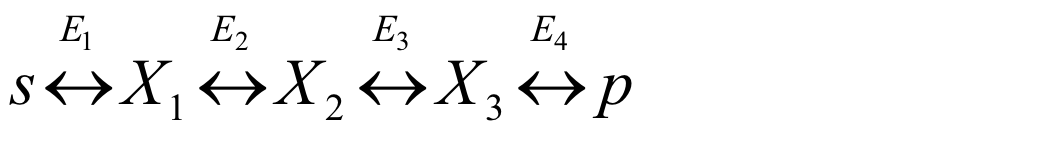

In [23]:
Image('equation.png')

Reactions 1, 3 and 4 are known to have the following underlying mechanism, which we shall call 'UniUni':

$$
\begin{align*}
E + S \iff ES \\
ES \iff EP \\
EP \iff E + P
\end{align*}
$$

In the first elementary reaction, the enzyme $E$ and substrate $S$ combine to form an enzyme-substrate complex $ES$. In the second elementary reaction, the substrate part of the complex turns into the product $P$, i.e. $ES$ turns into $EP$. In the third elementary reaction the product separates from the enzyme. While in normal conditions these reactions will all take place from left to right, for full generality we must also consider the reverse reaction in each case. In order to fully understand the reaction we therefore need to consider 6 elementary components.

Reaction 2 is assumed to be inhibited by the metabolite $X_3$. This reaction has a slightly more complicated elementary mechanism called 'Uni-Uni-inhib':

$$
\begin{align*}
E + S \iff ES \\
E + I \iff EI \\
ES \iff EP \\
EP \iff E + P
\end{align*}
$$

## Experiment
To carry out the experiment, the components of the system were left in a test tube, and the concentrations of the internal metabolites $X_1, ..., X_3$ were allowed to vary, while the concentrations of external metabolites $S$ and $P$, as well as the enzymes $E_1,..., E_4$ were kept constant. The tube was left for a long time in these conditions so that it eventually it became safe to assume that the concentrations of internal metabolites was no longer changing - in other words, the system had reached a 'steady state'. The internal metabolite concetrations were then measured, as was the overall flux through the system, called $v$. The experiment was repeated with a variety of enzyme and external metabolite concentrations, leading to the following results:

In [24]:
data = pd.read_csv('data.csv', index_col=0)
data

,E1,E2,E3,E4,s,p,X1,X2,X3,v
Ex_1,1,1,1,2,1.0,1,0.90,0.9,0.75,0.11
Ex_2,1,2,1,1,1.0,1,0.90,1.2,1.10,0.12
Ex_3,1,1,1,1,0.5,2,0.65,0.9,1.30,0.05
Ref,1,1,1,1,1.0,1,1.00,1.0,1.00,0.10


## Modelling strategy
This notebook explores how to learn from this data, taking advantage of the rich information that is available about how the underlying reaction system. The overall strategy is as follows:

1. Formulate a rate equation for each reaction, specifying how fast it will proceed as a function of some unknown parameters and known experimental conditions.
2. Use our knowledge of the overall reaction system to express the rates of change of each internal metabolite concentration as a function of the system's rate equations - at steady state this rate will be zero.
3. Solve the resulting system of ordinary differential equations so that (at steady state) the internal metabolite concentrations can be expressed as  functions of parameters and conditions governing rate equations.
4. Express non-experimental information about the reactions as probability distributions over the unknown parameters, and express the experimental information as a probabilistic measurement model.
5. Combine the experimental and non-experimental information with a Bayesian statistical model.

For simplicity we use the same simple measurement model in each case - measured concentrations and fluxes are unbiased draws from a normal distribution centered at the true values, with known variance. 

The notebook will explore three different ways of parameterising the system's reaction rates and representing the available information as probability distributions over these parameters' possible values.

1. **'Big K' approach**

   This approach represents each reaction's rate in terms of macroscopic parameters, with the elementary reactions not being represented explicitly. Each macroscopic parameter is given a weakly informative prior distribition.
   
2. **'Small k' approach**

   Reaction rates are expressed in terms of elementary reactions. Each elementary rate constant is given a 

1. **'Small k' approach with auxiliary parameters**

   This approach takes advantage of the fact that the 
  

## Testing that the functions behave as expected

The Stan code using auxilliary parameters uses some functions that I copied from GRASP. I used the cells below to test whether these functions were working properly.

The first cell tests the function `get_small_k_uni_uni.stan` against some numbers from GRASP.

In [2]:
uni_uni_model = pystan.StanModel(file='test_get_small_k_uni_uni.stan')

reversibility_proportional = np.array([0.1140, 0.4452, 0.4408])
enzyme_abundance_raw = np.array([0.7899, 0.0654, 0.1447])
expected_result = np.array([ 0.3402, 2.4271, 1.9285, 0.1115, 0.8744, 0.0209])
gibbs = -11.4499
reaction_flux = 0.11
RT = 2.4788

data = {
    'reversibility_proportional': reversibility_proportional,
    'enzyme_abundance_raw': enzyme_abundance_raw,
    'gibbs': gibbs,
    'reaction_flux': reaction_flux
}

uni_uni_fit = uni_uni_model.sampling(data=data, iter=1, chains=1, algorithm='Fixed_param')
function_result = uni_uni_fit['small_k'].reshape(-1).round(4)

print(f'expected result: {expected_result}')
print(f'function result: {function_result}')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d4f996f725848e5ccb5e31ff8d54724 NOW.


expected result: [0.3402 2.4271 1.9285 0.1115 0.8744 0.0209]
function result: [0.3402 2.4266 1.9286 0.1115 0.8743 0.0209]


The next cell uses the same method to test the Stan function `get_small_k_uni_uni_inhib`. The only difference is that this  function needs one more input - `elementary_flux_modifier`.

In [20]:
uni_uni_inhib_model = pystan.StanModel(file='test_get_small_k_uni_uni_inhib.stan')
reversibility_proportional = np.array([0.1252, 0, 0.5721, 0.3027])
enzyme_abundance_raw = np.array([0.1926, 0.1294, 0.2662, 0.4118])
expected_result = np.array([0.9178 ,0.5159, 0.6231, 0.3029, 0.8601, 0.0032, 0.2952, 0.0599])
gibbs = -19.2777
reaction_flux = 0.11
RT = 2.4788
elementary_flux_modifier = 0.7330

data = {
    'reversibility_proportional': reversibility_proportional,
    'enzyme_abundance_raw': enzyme_abundance_raw,
    'gibbs': gibbs,
    'reaction_flux': reaction_flux,
    'elementary_flux_modifier': elementary_flux_modifier
}

uni_uni_inhib_fit = uni_uni_inhib_model.sampling(data=data, iter=1, chains=1, algorithm='Fixed_param')
function_result = uni_uni_inhib_fit['small_k'].reshape(-1).round(4)

print(f'expected result: {expected_result}')
print(f'function result: {function_result}')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_214bf2ba052a96e28b3baf5324303633 NOW.


expected result: [0.9178 0.5159 0.6231 0.3029 0.8601 0.0032 0.2952 0.0599]
function result: [0.9178 0.5159 0.6231 0.3029 0.8601 0.0032 0.2952 0.0599]
